In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import unicodedata
import re
import string
import tensorflow as tf
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix
import random
random.seed(42)

# import nltk
# from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

0.6394267984578837
/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv


In [3]:
df = pd.read_csv('/kaggle/input/nlp-getting-started/train.csv')
print(df[df['target']==0].head(10))
print(df[df['target']==1].head(10))

    id keyword location                          text  target
15  23     NaN      NaN                What's up man?       0
16  24     NaN      NaN                 I love fruits       0
17  25     NaN      NaN              Summer is lovely       0
18  26     NaN      NaN             My car is so fast       0
19  28     NaN      NaN  What a goooooooaaaaaal!!!!!!       0
20  31     NaN      NaN        this is ridiculous....       0
21  32     NaN      NaN             London is cool ;)       0
22  33     NaN      NaN                   Love skiing       0
23  34     NaN      NaN         What a wonderful day!       0
24  36     NaN      NaN                      LOOOOOOL       0
   id keyword location                                               text  \
0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...   
1   4     NaN      NaN             Forest fire near La Ronge Sask. Canada   
2   5     NaN      NaN  All residents asked to 'shelter in place' are ...   
3   6     

Here we can see snapshots of the data we are working with. There is a total of 7,613 rows (entries) which we can use for training and validating our model. In the "text" column, the tweets to be categorized are entered. In the "target" column is the label of disaster (1) or not a disaster tweet (0). There are two more additional columns, "keyward" and "location", but these are obviously incomplete. Ways to handle this are we can omit the columns or omit the rows. We will omit the columns to keep as many datapoints as possible.

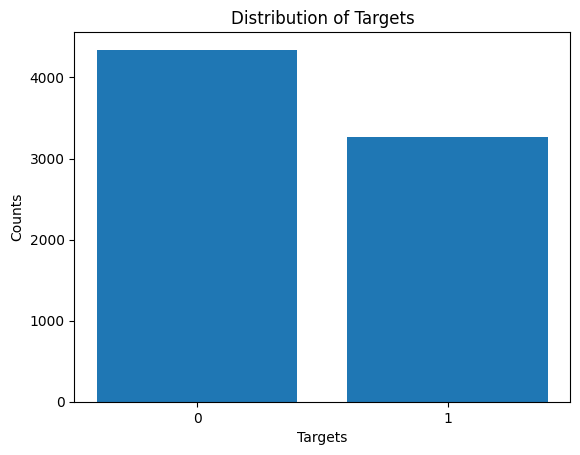

In [19]:
targets = [str(0), str(1)]
values = [len(df[df['target']==0]), len(df[df['target']==1])]
plt.bar(targets, values)
plt.xlabel('Targets')
plt.ylabel('Counts')
plt.title('Distribution of Targets')
plt.show()

Preprocessing data:
1. First, I attempt to "normalize" the data by getting rid of special characters. I create a function unicode_to_ascii() which will transform all characters into ASCII.

2. I convert the string of text into a list of words, and simultaneously filter out any words that are $\le$2 characters long and remove punctuation. This will allow the RNN to cycle through a smaller list of more meaningful words.

In [20]:
ALL_LETTERS = string.ascii_letters+ "\/ ,.;:'0123456789[]{}<>"
def unicode_to_ascii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in ALL_LETTERS
    )

def remove_punctuation(s):
    return re.sub(r"[" + re.escape(string.punctuation) + r"]", "", s)

def remove_2letters(s):
    my_list = s.split()
    return  ' '.join(['{:.2f}'.format(i) if type(i) == float else str(i) for i in my_list])

# Example of using unicode_to_ascii()
print(unicode_to_ascii('á, é, í, ó, ú'))

# Example of using remove_punctuation()
print(remove_punctuation('Hello! All, punctuat.ions +removed?'))

# Example of using remove_2letters()
print(remove_2letters('Of these words, which do I keep or remove?'))

a, e, i, o, u
Hello All punctuations removed
Of these words, which do I keep or remove?


Now you can see that there are less "useless" words such as "or", "in", "of", "is", etc. Also, there won't be any meaningless duplicates due to capitilizations. For example, "Sweet" and "sweet" will be treated the same. 

In [21]:
for i, tweet in enumerate(df['text']):
    df.at[i, 'text'] = remove_2letters(unicode_to_ascii(remove_punctuation(tweet)))
df

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this earthquake Ma...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask Canada,1
2,5,NaN,NaN,All residents asked to shelter in place are be...,1
3,6,NaN,NaN,13000 people receive wildfires evacuation orde...,1
4,7,NaN,NaN,Just got sent this photo from Ruby Alaska as s...,1
...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,ariaahrary TheTawniest The out of control wild...,1
7610,10871,NaN,NaN,M194 0104 UTC5km S of Volcano Hawaii httptcozD...,1
7611,10872,NaN,NaN,Police investigating after an ebike collided w...,1


We then shuffle the dataset because as you can see above, it seems that the 1 and 0 targets are grouped together. This will affect our training as there won't be a truly homogenous learning of both 1 and 0 cases.

In [22]:
df = df.sample(frac=1).reset_index(drop=True)
df

,id,keyword,location,text,target
0,4522,emergency,"Indianapolis, IN",UPDATE Indiana State Police reopening I65 near...,1
1,1091,blew%20up,Seattle,Hw18 going 90100 Dude was keeping up with me T...,0
2,8613,seismic,NaN,SEISMIC AUDIO SA15T SA15T Padded Black Speaker...,0
3,4157,drown,NaN,When you lowkey already know youre gonna drown...,0
4,9620,thunderstorm,"El Dorado, Arkansas",NWS has Continued a Severe Thunderstorm Warnin...,1
...,...,...,...,...,...
7608,1662,bombing,North East USA,What it was like to survive the atomic bombing...,1
7609,5099,famine,"Tampa, FL",UPDATE 1Russian food crematoria provoke outrag...,1
7610,1502,body%20bags,D.C. - Baltimore - Annapolis,UPDATE Va firefighter on administrative leave ...,0
7611,1211,blizzard,lakewood colorado,FAIRx818x PlayOverwatch BlizzardCS please bliz...,0


Here we split the dataset into training and testing. We will arbitrarily use the last 1,000 entries for validation (approximately 13%) of the dataset. The rest will be used for training.

In [23]:
df_train = df.iloc[:-1000, -2:]
df_train['target'] = np.asarray(df_train['target']).astype(np.float32)

df_test = df.iloc[-1000:, -2:]
df_test['target'] = np.asarray(df_test['target']).astype(np.float32)

example, label = next(iter(df_train['text'])), next(iter(df_train['target']))

print('Text:', example)
print('Label: ', label)

Text: UPDATE Indiana State Police reopening I65 near Lafayette following emergency bridge repairs that closed key highway for about 28 hours
Label:  1.0


In order to turn the words into something more computationally manageable, we will map the text features to integer sequences using TextVectorization(). An example of transforming text into vectors and back into text is shown.

In [24]:
encoder = tf.keras.layers.TextVectorization()
encoder.adapt(df_train['text'])

vocabulary = np.array(encoder.get_vocabulary())

original_text = example
encoded_text = encoder(original_text)
decoded_text = ' '.join(vocabulary[encoded_text])

print('original: ', original_text)
print('encoded: ', encoded_text)
print('decoded: ', decoded_text)

original:  UPDATE Indiana State Police reopening I65 near Lafayette following emergency bridge repairs that closed key highway for about 28 hours
encoded:  tf.Tensor(
[  441 12069   235    83  3333 12232   225 11399  1023    73   388  4586
    15   832  3568  1481    10    52  6120   600], shape=(20,), dtype=int64)
decoded:  update indiana state police reopening i65 near lafayette following emergency bridge repairs that closed key highway for about 28 hours


We will investigate 3 types of RNN models: simple, LSTM, and GRU (covered in class). First we will establish callbacks to make creating the aforementioned models easier.

RNNs are best for this type of problem because we are handling a sequence of words in a tweet. And in speech, sequential order of texts is important as it gives context and meaning to the words being used.

All 3 types of RNN have been covered in lectures. Simple RNN are the most vanilla but they are prone to slow training, exploding/vanishing gradients, and also early memory/information gets lost through time steps. LSTM (Long Short Term Memory) are more complex and add on a long term memory component (Simple RNN only has the short term). GRU (Gradient Recurrent Unit) is another model, more complicated than Simple RNN but honed down compared to LSTM.

In [8]:
es = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',  # Metric to monitor
    mode='max',
    patience=3,         # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True # Restore model weights from the epoch with the best value of the monitored quantity
)

epochs=10

In [9]:
# Creating the model
model_simple = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        len(encoder.get_vocabulary()), 64, mask_zero=True),
    tf.keras.layers.Bidirectional(
        tf.keras.layers.SimpleRNN(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.SimpleRNN(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])
 
# Summary of the model
# model.summary()
 
# Compile the model
model_simple.compile(
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy']
)

history_simple = model_simple.fit(
    x=df_train['text'],
    y=df_train['target'],
    epochs=epochs,
    validation_data=(df_test['text'], df_test['target']),
    callbacks=[es]
)

Epoch 1/10
207/207 ━━━━━━━━━━━━━━━━━━━━ 29s 98ms/step - accuracy: 0.6243 - loss: 0.6286 - val_accuracy: 0.8020 - val_loss: 0.4472
Epoch 2/10
207/207 ━━━━━━━━━━━━━━━━━━━━ 19s 94ms/step - accuracy: 0.9110 - loss: 0.2223 - val_accuracy: 0.7560 - val_loss: 0.6327
Epoch 3/10
207/207 ━━━━━━━━━━━━━━━━━━━━ 20s 96ms/step - accuracy: 0.9816 - loss: 0.0590 - val_accuracy: 0.7260 - val_loss: 0.7975
Epoch 4/10
207/207 ━━━━━━━━━━━━━━━━━━━━ 20s 95ms/step - accuracy: 0.9893 - loss: 0.0277 - val_accuracy: 0.7560 - val_loss: 0.8550


In [10]:
model_lstm = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        len(encoder.get_vocabulary()), 64, mask_zero=True),
    tf.keras.layers.Bidirectional(
        tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

model_lstm.compile(
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy']
)

history_lstm = model_lstm.fit(
    x=df_train['text'],
    y=df_train['target'],
    epochs=epochs,
    validation_data=(df_test['text'], df_test['target']),
    callbacks=[es]
)

Epoch 1/10
207/207 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - accuracy: 0.6590 - loss: 0.5855 - val_accuracy: 0.8040 - val_loss: 0.4287
Epoch 2/10
207/207 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9050 - loss: 0.2325 - val_accuracy: 0.7780 - val_loss: 0.5941
Epoch 3/10
207/207 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9737 - loss: 0.0824 - val_accuracy: 0.7650 - val_loss: 0.7145
Epoch 4/10
207/207 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9863 - loss: 0.0475 - val_accuracy: 0.7460 - val_loss: 0.9166


In [11]:
model_gru = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        len(encoder.get_vocabulary()), 64, mask_zero=True),
    tf.keras.layers.Bidirectional(
        tf.keras.layers.GRU(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

model_gru.compile(
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy']
)

history_gru = model_gru.fit(
    x=df_train['text'],
    y=df_train['target'],
    epochs=epochs,
    validation_data=(df_test['text'], df_test['target']),
    callbacks=[es]
)

Epoch 1/10
207/207 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - accuracy: 0.6565 - loss: 0.5960 - val_accuracy: 0.8090 - val_loss: 0.4386
Epoch 2/10
207/207 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9097 - loss: 0.2291 - val_accuracy: 0.7810 - val_loss: 0.5433
Epoch 3/10
207/207 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9755 - loss: 0.0726 - val_accuracy: 0.7780 - val_loss: 0.6351
Epoch 4/10
207/207 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9888 - loss: 0.0400 - val_accuracy: 0.7790 - val_loss: 0.8283


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.7904 - loss: 0.4725
SimpleRNN: [0.4471663236618042, 0.8019999861717224] 

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7888 - loss: 0.4485
LSTM: [0.4287324845790863, 0.8040000200271606] 

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7965 - loss: 0.4570
GRU: [0.4386407434940338, 0.8090000152587891] 

32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step


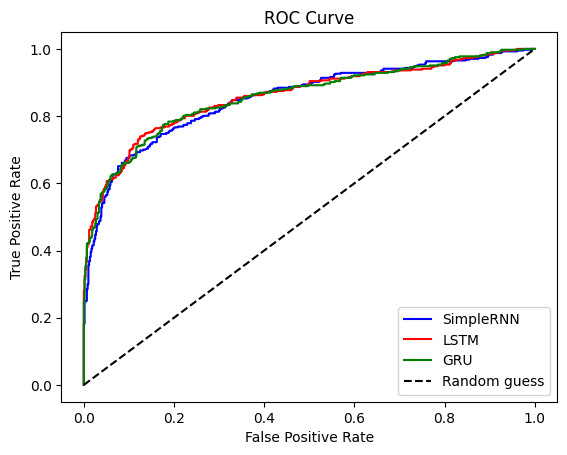

AUC of SimpleRNN: 0.854
AUC of LSTM: 0.859
AUC of GRU: 0.858


In [12]:
print('SimpleRNN:', model_simple.evaluate(df_test['text'], df_test['target']), '\n')
print('LSTM:', model_lstm.evaluate(df_test['text'], df_test['target']), '\n')
print('GRU:', model_gru.evaluate(df_test['text'], df_test['target']), '\n')

yp_simple = model_simple.predict(df_test['text'])
fpr_simple, tpr_simple, thresh_simple = roc_curve(df_test['target'], yp_simple)

yp_lstm = model_lstm.predict(df_test['text'])
fpr_lstm, tpr_lstm, thresh_lstm = roc_curve(df_test['target'], yp_lstm)

yp_gru = model_gru.predict(df_test['text'])
fpr_gru, tpr_gru, thresh_gru = roc_curve(df_test['target'], yp_gru)

plt.plot(fpr_simple, tpr_simple, label='SimpleRNN', c='blue')
plt.plot(fpr_lstm, tpr_lstm, label='LSTM', c='red')
plt.plot(fpr_gru, tpr_gru, label='GRU', c='green')
plt.plot([0,1], [0,1], 'k--', label='Random guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

auc_simple = roc_auc_score(df_test['target'], yp_simple)
auc_lstm = roc_auc_score(df_test['target'], yp_lstm)
auc_gru = roc_auc_score(df_test['target'], yp_gru)
print('AUC of SimpleRNN: %.3f' % auc_simple)
print('AUC of LSTM: %.3f' % auc_lstm)
print('AUC of GRU: %.3f' % auc_gru)

Although all very similar in accuracy, here we see that the LSTM is the best model for this dataset! However, the difference is in the thousandths and might not be relevant. Since all models performed similarly, improving each individual model might come from fine tuning the parameters, adding more neurons and layers, etc. Additionally, we disgregarded the "keyword" and "location" columns in our dataset due to incompleteness. We could try reincorporating them and restructuring our dataset to improve accuracy further. Regardless, we will use the LSTM model for submission because it produced the highest accuracy.

In [15]:
x_pred = pd.read_csv('/kaggle/input/nlp-getting-started/test.csv')
y_pred = model_lstm.predict(x_pred['text'])
submission = pd.DataFrame({'id':x_pred['id'], 'target':[1 if p>0 else 0 for p in y_pred]})
submission.to_csv('submission.csv', index=False)

102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
